In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import windIO
import foam
import wind
import windBLWT as wt

In [3]:
datadir = r"D:/OneDrive - The University of Western Ontario/Documents/CollabWorks/PeakWithML/Data/sampleData_1.0/"

profileDir = r"D:/OneDrive - The University of Western Ontario/Documents/Projects/NRC_fieldMonitoring/NRC_gable27deg/Data/windTunnel/profiles/"

rawHFPIdir = r"E:/nrcNB_windTunnelData/rawHFPI/"
exps = ['E2','E3']
cases = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
exp = exps[0]
caseID = cases[1]
caseToRun = 'nrcNB'+caseID+exp
casedir = rawHFPIdir+caseToRun+r"/"

H = 0.08

In [4]:
sFreq = 1600
dt = 1/sFreq

pDir =profileDir+"tngE2/"
Z = np.squeeze(pd.read_csv(pDir+"Z.csv"))
U_TH = np.load(pDir+"UofT.npy")
V_TH = np.load(pDir+"VofT.npy")
W_TH = np.load(pDir+"WofT.npy")
vel = wind.profile(name="BLWT - OP", Z=Z,UofT=U_TH,VofT=V_TH,WofT=W_TH,H=H,dt=dt,nSpectAvg=32,keepTH=True)

del(U_TH, V_TH, W_TH)

In [5]:
prof = pd.DataFrame()

Z = np.array(vel.Z/vel.H)
U = vel.U/vel.Uh
Iu = vel.Iu
Iv = vel.Iv
Iw = vel.Iw
uw = vel.uw/(vel.Uh**2)
xLu = vel.xLu/vel.H
xLv = vel.xLv/vel.H
xLw = vel.xLw/vel.H

# print(Z[-1])

Z2 = np.sort(np.append(np.logspace(np.log10(Z[0]), np.log10(Z[-1]), 99), 1.0))
prof['Z'] = Z2
prof['U'] = np.interp(Z2, Z, U)
prof['Iu'] = np.interp(Z2, Z, Iu)
prof['Iv'] = np.interp(Z2, Z, Iv)
prof['Iw'] = np.interp(Z2, Z, Iw)
prof['uw'] = np.interp(Z2, Z, uw)
prof['xLu'] = np.interp(Z2, Z, xLu)
prof['xLv'] = np.interp(Z2, Z, xLv)
prof['xLw'] = np.interp(Z2, Z, xLw)

print(prof)

prof.to_csv(datadir+"profiles.csv", index=False, header=True)

            Z         U        Iu        Iv        Iw        uw        xLu  \
0    0.123825  0.696447  0.232028  0.174027  0.081295  0.001483  12.700403   
1    0.130767  0.700523  0.231579  0.173454  0.081342  0.001517  12.773212   
2    0.138099  0.704828  0.231105  0.172849  0.081392  0.001553  12.850102   
3    0.145842  0.709375  0.230605  0.172210  0.081445  0.001591  12.931304   
4    0.154019  0.714176  0.230077  0.171536  0.081500  0.001631  13.017058   
..        ...       ...       ...       ...       ...       ...        ...   
95  20.882628  1.431849  0.084392  0.070801  0.060855  0.001515  15.991016   
96  22.053443  1.419957  0.085100  0.073301  0.059553  0.002200  14.043025   
97  23.289901  1.404343  0.087259  0.076026  0.058519  0.002755  16.337720   
98  24.595683  1.386071  0.092705  0.080166  0.058270  0.003334  16.314878   
99  25.974675  1.349591  0.098033  0.088246  0.058678  0.003747  15.340872   

         xLv       xLw  
0   6.267110  0.301309  
1   6.378598 

(1000,)


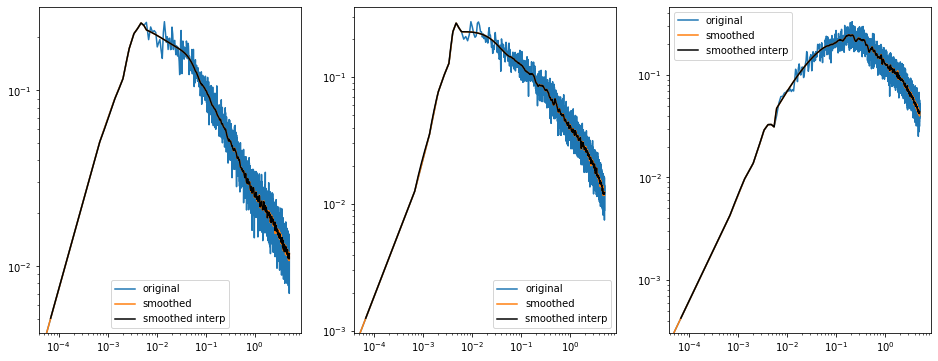

In [6]:
from scipy.signal import savgol_filter

f = vel.SpectH.rf()[:-60]
f2 = np.logspace(np.log10(f[1]*0.1), np.log10(f[-1]), 1000)

Suu_orig = vel.SpectH.rSuu(normU='sigUi')[:-60]
Suu = Suu_orig.copy()
Suu[9:] = savgol_filter(Suu_orig[9:], 151, 5)
Suu2 = np.interp(f2, f, Suu)

Svv_orig = vel.SpectH.rSvv(normU='sigUi')[:-60]
Svv = Svv_orig.copy()
Svv[9:] = savgol_filter(Svv_orig[9:], 151, 5)
Svv2 = np.interp(f2, f, Svv)

Sww_orig = vel.SpectH.rSww(normU='sigUi')[:-60]
Sww = Sww_orig.copy()
Sww[9:] = savgol_filter(Sww_orig[9:], 151, 5)
Sww2 = np.interp(f2, f, Sww)

plt.figure(figsize=[16,6])
plt.subplot(1,3,1)
plt.loglog(f, Suu_orig, label='original')
plt.loglog(f, Suu, label='smoothed')
plt.loglog(f2, Suu2, '-k', label='smoothed interp')
plt.legend()

plt.subplot(1,3,2)
plt.loglog(f, Svv_orig, label='original')
plt.loglog(f, Svv, label='smoothed')
plt.loglog(f2, Svv2, '-k', label='smoothed interp')
plt.legend()

plt.subplot(1,3,3)
plt.loglog(f, Sww_orig, label='original')
plt.loglog(f, Sww, label='smoothed')
plt.loglog(f2, Sww2, '-k', label='smoothed interp')
plt.legend()

print(np.shape(Suu2))


In [7]:
spect = pd.DataFrame()
spect['f'] = f2
spect['Suu'] = Suu2
spect['Svv'] = Svv2
spect['Sww'] = Sww2

spect.to_csv(datadir+"spectra.csv", index=False, header=True)

print(spect)


            f       Suu       Svv       Sww
0    0.000068  0.005079  0.001263  0.000424
1    0.000069  0.005136  0.001277  0.000429
2    0.000070  0.005194  0.001292  0.000434
3    0.000070  0.005253  0.001306  0.000439
4    0.000071  0.005312  0.001321  0.000444
..        ...       ...       ...       ...
995  4.839503  0.011542  0.011915  0.045193
996  4.894152  0.011121  0.011930  0.042597
997  4.949418  0.011330  0.012386  0.042654
998  5.005308  0.011016  0.012022  0.041928
999  5.061829  0.011828  0.012273  0.043661

[1000 rows x 4 columns]


In [8]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 2909,
                'main_pitot_queue': 2910,
                '20inch_pitot_zero': 2907,
                '20inch_pitot_queue': 2908,
                'Uh_pitot_zero': 2905,
                'Uh_pitot_queue': 2906,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
# peakSpecs = {
#                 'method':'minmax',
#             }
peakSpecs['Num_seg'] = 10
peakSpecs['Duration'] = 10
peakSpecs['prob_non_excd'] = 0.8

In [9]:
cp_raw = wt.BLWTL_HFPI(
    caseDir=casedir,
    userNotes=None,
    Z_MainPitot=1.48,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    # lowpassFreq=200.0,
    lowpassFreq=222.223,
    Ntaps=440,
)
print((cp_raw.CpTH.shape))


(40, 440, 40000)


In [10]:
Uh = np.interp(H, vel.Z, vel.U)
Upitot = np.interp(cp_raw.Z_MainPitot, vel.Z, vel.U)
velRatio = Upitot/ Uh

In [11]:
cpdata = cp_raw.CpTH[:3,:,:].copy() * velRatio**2

print(cpdata.shape)
cpdata = np.reshape(cpdata, (-1, cpdata.shape[-1]))
print(cpdata.shape)

np.save(datadir+"cpdata.npy", cpdata)

# cpd = pd.DataFrame(cpdata)
# cpd.to_csv(datadir+"cpdata.csv", index=False, header=False)

(3, 440, 40000)
(1320, 40000)


In [12]:
cpst = wind.get_CpTH_stats(cpdata,axis=1,fields=['mean','std','skewness','kurtosis','peakMin','peakMax'])

peakMin, peakMax, details = wind.peak(cpdata,axis=1,detailedOutput=True)

print(details.keys())
print(np.shape(details['mu_max']))

cpstats = pd.DataFrame()
cpstats['meanCp'] = cpst['mean']
cpstats['stdCp'] = cpst['std']
cpstats['skewCp'] = cpst['skewness']
cpstats['kurtCp'] = cpst['kurtosis']
cpstats['minCp'] = cpst['peakMin']
cpstats['mu_min'] = details['mu_min']
cpstats['sig_min'] = details['sig_min']
cpstats['maxCp'] = cpst['peakMax']
cpstats['mu_max'] = details['mu_max']
cpstats['sig_max'] = details['sig_max']

cpstats.to_csv(datadir+"cpstats.csv", index=False, header=True)

dict_keys(['ai', 'bi', 'x_max', 'x_min', 'mu_max', 'mu_min', 'sig_max', 'sig_min'])
(1320,)
